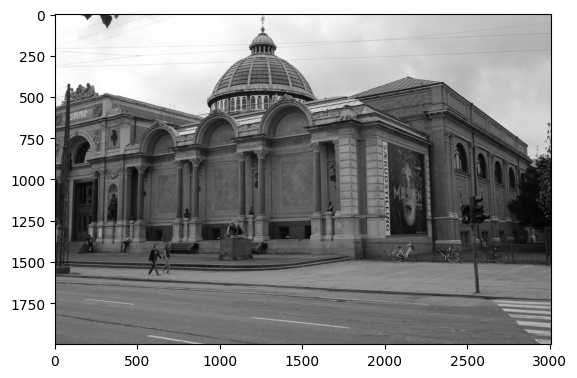

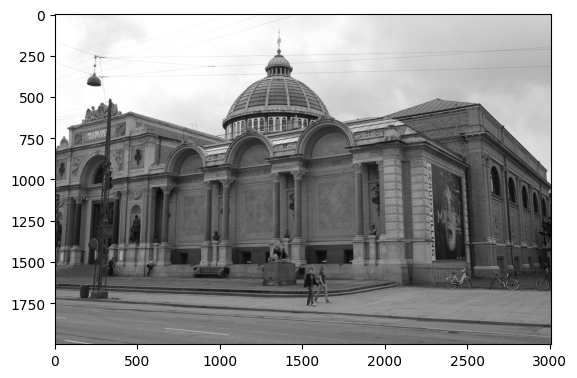

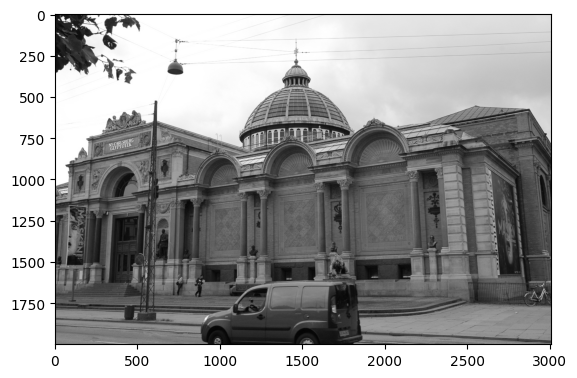

In [28]:
#ex 11 - 12
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

K = np.loadtxt('./Glyp/K.txt')
im0 = cv2.imread('./Glyp/sequence/000001.png')
im1 = cv2.imread('./Glyp/sequence/000002.png')
im2 = cv2.imread('./Glyp/sequence/000003.png')

plt.imshow(im0)
plt.show()

plt.imshow(im1)
plt.show()

plt.imshow(im2)
plt.show()


In [29]:
cv2.__version__

'4.7.0'

In [30]:
#part 11.1
'''
Find SIFT keypoints (kp0, kp1, kp2) in all three images and compute their corresponding descriptors (des0, des1, des2).
For speed reasons, you can limit the number of SIFT features to 2000. Convert the features to numpy arrays of 2D points
'''

sift = cv2.SIFT_create(nfeatures = 2000)

# Detect keypoints and compute descriptors
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher_create(crossCheck= True)
matches_01 = bf.match(des0, des1)
matches_01 = np.array([(m.queryIdx, m.trainIdx) for m in matches_01])


matches_12 = bf.match(des1, des2)
matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in matches_12])


print(matches_01.shape)
print(matches_12.shape)

#matching01_result = cv2.drawMatches(im0, kp0, im1, kp1, matches_01[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


(958, 2)
(860, 2)


In [31]:
matches_01

array([[   2,  224],
       [   3,  225],
       [   8,  184],
       ...,
       [1990, 1782],
       [1993, 1775],
       [1998, 1976]])

In [74]:
#part 11.2
'''estimate essential matrix between im0 and im1 wirth ransac'''
# Define the RANSAC threshold and probability
ransac_threshold = 1.0  
ransac_prob      = 0.99      

# Estimate the essential matrix using RANSAC
E_01, mask_01 = cv2.findEssentialMat(kp0[matches_01[:, 0]], kp1[matches_01[:, 1]], K)
#     ^^ The mask returned by this function indicates which of the matches are inliers.
#print(mask_01.shape)
#print(mask_01.sum()) = 680 inliers

print(E_01/E_01[2,2])

#Decompose the essential matrix and find the correct relative pose (R1, t1).
retval, R1, t1, mask = cv2.recoverPose(E_01, kp0[matches_01[:, 0]], kp1[matches_01[:, 1]], K)
                # ^^ The mask returned by cv2.recoverPose indicates which matches, that lie in front of both cameras
mask_01_p = (mask/255).astype(int)
print(mask_01_p.shape)
print(R1)

#combine the mask from rec pose and find essential mat
combined_mask_01 = np.logical_and(mask_01, mask_01_p) #these matches are both inliers and lie in front of the cameras
print(combined_mask_01.shape)

#keep only the inliers in matches_01
new_matches_01 = matches_01[combined_mask_01.ravel()]

#print(new_matches_01)
num_inliers_combined_01 = new_matches_01.shape
print("Number of inliers after combining masks 01:", num_inliers_combined_01)




[[  0.07486536   8.74589182  -1.15356838]
 [ -8.89272323   1.10437756 -21.45366232]
 [  1.7883347   21.52741224   1.        ]]
(958, 1)

[[ 0.99989796 -0.00991561 -0.01028382]
 [ 0.0103896   0.99883564  0.04711083]
 [ 0.00980472 -0.04721287  0.99883673]]

(958, 1)
Number of inliers after combining masks 01: (680, 2)
Number of inliers after combining masks 12: (517, 2)


(359,)
(359,)


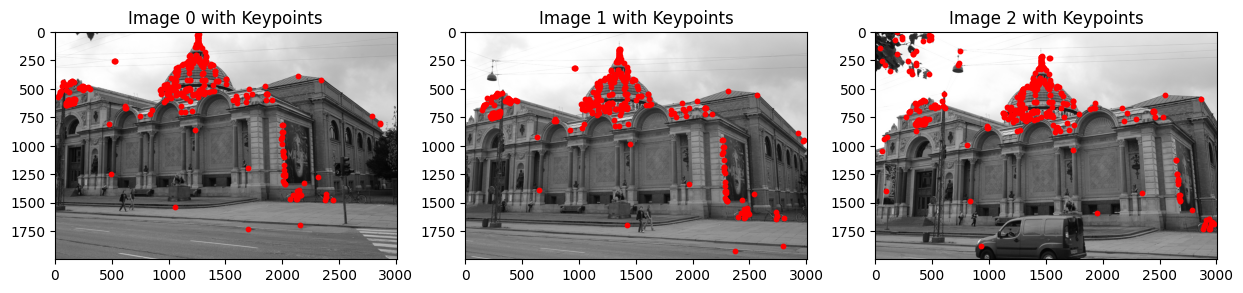

In [84]:
#part 11.3

'''Use matches01 and matches12 and find the subset of matches such that we can match features all the way from image 0 to image 2. 
In other words, create three lists such that points0[i], points1[i], and points2[i] are the 2D locations of the same point in the corresponding images.
'''

#this finds common keypoints in image 1 between images 0 and 2
_, idx01, idx12 = np.intersect1d(new_matches_01[:,1], matches_12[:,0], return_indices=True)

print(idx01.shape)
print(idx12.shape)

points0_matched = []
points1_matched = []
points2_matched = []

points0_matched = (kp0[new_matches_01[idx01, 0]])
points1_matched = (kp1[new_matches_01[idx01, 1]])
points2_matched = (kp2[matches_12[idx12, 1]])

# Convert the lists to numpy arrays
points0_matched = np.array(points0_matched)
points1_matched = np.array(points1_matched)
points2_matched = np.array(points2_matched)

# Plot the keypoints on images 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image 0 with keypoints
axes[0].imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))
axes[0].scatter(points0_matched[:, 0], points0_matched[:, 1], c='r', s=10)
axes[0].set_title('Image 0 with Keypoints')

# Plot image 1 with keypoints
axes[1].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axes[1].scatter(points1_matched[:, 0], points1_matched[:, 1], c='r', s=10)
axes[1].set_title('Image 1 with Keypoints')

# Plot image 2 with keypoints
axes[2].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axes[2].scatter(points2_matched[:, 0], points2_matched[:, 1], c='r', s=10)
axes[2].set_title('Image 2 with Keypoints')

plt.show()


In [82]:
points2_matched.shape

(1, 359, 2)

In [78]:
#part 11.4
#For the points that have been tracked through all three images, 
#use the 2D positions in image 0 and 1 to triangulate the points in 3D (Q)
from util_functions import pi

'''Triangulating points in 3D from multiple camera images involves several steps where 
you determine the 3D coordinates of a point from its projections 
(its observed locations in two or more images)
'''

#we need K -> converts 3d cam coords to 2d Img coords
#need r and t (relative orientation and position between cameras)
#correspondence between the same physical points in multiple images

#with this i can compute the 3D point that best correponds to these projections


'Triangulating points in 3D from multiple camera images involves several steps where \nyou determine the 3D coordinates of a point from its projections \n(its observed locations in two or more images)\n'

In [98]:
#already have R and t, but recalculate them with the points that actually match

#P = K @ [R|t]
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))#camera 1 is at the origin
P2 = K @ np.hstack((R1, t1.reshape(3,1)))

Q4d = cv2.triangulatePoints(P1, P2, points0_matched.T, points1_matched.T)
Q3d = Q4d[:3]/Q4d[3] #3 x n


print(points0_matched.shape)

print((Q3d).shape)

#Using the 2D positions in image 2, estimate the pose of image 2 with RANSAC. Use cv2.solvePnPRansac to do this
distCoeffs = np.zeros(5)
success, rvec, tvec, inliers = cv2.solvePnPRansac(Q3d.T, points2_matched, K, distCoeffs)


if success:
    print("Rotation Vector:\n", rvec)
    print("Translation Vector:\n", tvec)
    print("Inliers:\n", inliers.shape)
else:
    print("Pose estimation failed.")
    print("Rotation Vector:\n", rvec)
    print("Translation Vector:\n", tvec)
    print("Inliers:\n", inliers)


(359, 2)
(3, 359)
Rotation Vector:
 [[-0.07905618]
 [-0.01883398]
 [ 0.00386271]]
Translation Vector:
 [[ 1.97638112]
 [-0.24551975]
 [-1.06125151]]
Inliers:
 (275, 1)


In [97]:
((Q3d[inliers.flatten()])).shape

(275, 3)

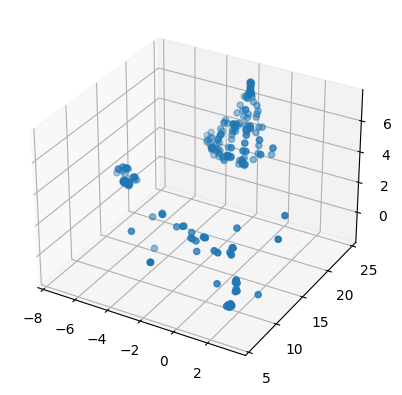

In [103]:
figure = plt.figure()
ax = figure.add_subplot(projection='3d')
points_show = (Q3d.T[inliers.flatten()]).T
points_show[[1,2], :] = points_show[[2,1], :]
points_show[2, :] *= -1
ax.scatter(*(points_show))
plt.show()
